# Import Package Dependencies

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.utils import shuffle
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Import Data for Gold Futures

In [ ]:
series = yf.Ticker("GC=F")
starting_cash = 100

prices_open = series.history(start='2014-01-01', end='2024-06-15').Open
prices_close = series.history(start='2014-01-01', end='2024-06-15').Close

returns_open = prices_open.pct_change().dropna()
returns_close = prices_close.pct_change().dropna()

In [ ]:
returns = returns_open
prices = prices_open

## Organize Training Data

In [ ]:
WINDOW_SIZE = 10

X_train = []
y_train = []

for i in range(len(returns)-WINDOW_SIZE-9):
    input_window = returns.iloc[i : i + WINDOW_SIZE]
    next_return = returns.iloc[i + WINDOW_SIZE]

    X_train.append(input_window)
    y_train.append(next_return)

## Organize 2 week Test Window

In [ ]:
X_test = []

for i in range(10,1,-1):
  input_window = returns.iloc[-10-i: -i]
  X_test.append(input_window)

In [ ]:
X_train = X_train[:-1]
y_train = y_train[:-1]

In [ ]:
X_test.append(returns.iloc[-11:-1])

# Fit Decision Tree Model on Time Series

In [ ]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Predict Over 2 Week Trading Period

In [ ]:
predictions = returns[-len(X_test):].copy()
for i in range(len(X_test)):
    X_test_df = pd.DataFrame([X_test[i]])
    predicted_value = model.predict(X_test_df)[0]
    date_index = predictions.index[i]
    predictions.at[date_index] = predicted_value

In [ ]:
print(predictions)

Date
2024-06-03 00:00:00-04:00    0.000732
2024-06-04 00:00:00-04:00   -0.003518
2024-06-05 00:00:00-04:00    0.006437
2024-06-06 00:00:00-04:00    0.007772
2024-06-07 00:00:00-04:00   -0.004649
2024-06-10 00:00:00-04:00    0.004544
2024-06-11 00:00:00-04:00   -0.005587
2024-06-12 00:00:00-04:00   -0.000858
2024-06-13 00:00:00-04:00    0.009739
2024-06-14 00:00:00-04:00    0.007578
Name: Open, dtype: float64


In [ ]:
trading_period = prices.iloc[-11:]
print(trading_period)

Date
2024-05-31 00:00:00-04:00    2344.100098
2024-06-03 00:00:00-04:00    2322.600098
2024-06-04 00:00:00-04:00    2347.500000
2024-06-05 00:00:00-04:00    2326.399902
2024-06-06 00:00:00-04:00    2355.000000
2024-06-07 00:00:00-04:00    2379.899902
2024-06-10 00:00:00-04:00    2290.600098
2024-06-11 00:00:00-04:00    2300.000000
2024-06-12 00:00:00-04:00    2314.899902
2024-06-13 00:00:00-04:00    2309.399902
2024-06-14 00:00:00-04:00    2307.000000
Name: Open, dtype: float64


# Buy at Open, Sell at Close if Predicted Returns

In [ ]:
def BuySellModelPredict(starting_cash):
    prices = trading_period
    revenue = np.zeros(len(predictions))
    cash = starting_cash
    cash_used = 0
    shares = 0
    holding = False

    for i in range (1, len(predictions)):
        if predictions[i-1] > 0:
            shares = starting_cash / prices[i-1]
            cash = shares * prices[i]
            cash_used += starting_cash
            revenue[i] = cash - starting_cash
            holding = True

        print(f"Day {i}: \n Daily Open = {prices[i-1]},  \n Daily Close = {prices[i]},  \n Cash = {cash}, \n Shares = {shares}, \n Prediction = {predictions[i-1]}, \n Daily Revenue = {revenue[i]}, \n")

    if holding:
        cash = shares * prices[-1]
        revenue[-1] = cash - starting_cash
        print(f"Day {i+1}: Forced Sell: Close = {prices[-1]}, Cash = {cash}, Revenue = {revenue[-1]}")

    #   plt.figure(figsize=(10, 4))
    #   plt.plot(revenue)
    #   plt.ylabel('Revenue', fontsize=20)
    #   plt.xlabel('Hour', fontsize=20)
    #   plt.title('Revenue Over Time', fontsize=20)
    #   plt.show()

    plt.figure(figsize=(10, 4))
    days = range(len(revenue))
    plt.scatter(days, revenue, color='blue', label='Revenue')
    plt.plot(days, revenue, color='blue')
    plt.ylabel('Revenue', fontsize=20)
    plt.xlabel('Day', fontsize=20)
    plt.title('Revenue Over Time', fontsize=20)
    plt.legend()

    # Set x-axis ticks at intervals of 24
    xticks = range(0, len(revenue), 24)
    plt.xticks(xticks)

    # Annotate each point with the revenue value
    for day, rev in zip(days, revenue):
        plt.text(day, rev, f'{round(rev, 2)}', fontsize=7, ha='left', va='bottom')

    plt.show()
    total_revenue = 0
    for i in range(len(revenue)):
        total_revenue += revenue[i]
    print('Cash Used: ', cash_used)
    return total_revenue

Day 1: 
 Daily Open = 2344.10009765625,  
 Daily Close = 2322.60009765625,  
 Cash = 99.08280367286804, 
 Shares = 0.04266029428520782, 
 Prediction = 0.0007317010313272476, 
 Daily Revenue = -0.9171963271319612, 

Day 2: 
 Daily Open = 2322.60009765625,  
 Daily Close = 2347.5,  
 Cash = 99.08280367286804, 
 Shares = 0.04266029428520782, 
 Prediction = -0.0035179771948605776, 
 Daily Revenue = 0.0, 

Day 3: 
 Daily Open = 2347.5,  
 Daily Close = 2326.39990234375,  
 Cash = 99.10116729898829, 
 Shares = 0.042598509052183174, 
 Prediction = 0.006436728406697512, 
 Daily Revenue = -0.8988327010117132, 

Day 4: 
 Daily Open = 2326.39990234375,  
 Daily Close = 2355.0,  
 Cash = 101.2293715120705, 
 Shares = 0.04298487113039087, 
 Prediction = 0.007772244047373533, 
 Daily Revenue = 1.2293715120705002, 

Day 5: 
 Daily Open = 2355.0,  
 Daily Close = 2379.89990234375,  
 Cash = 101.2293715120705, 
 Shares = 0.04298487113039087, 
 Prediction = -0.004648670554161072, 
 Daily Revenue = 0.0, 

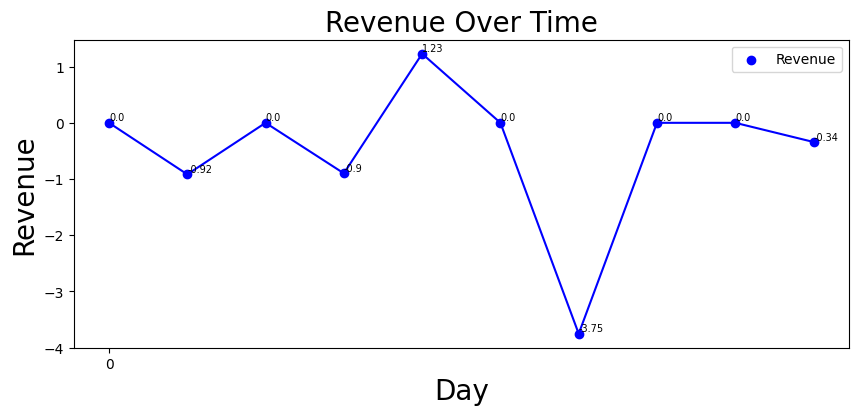

Cash Used:  500


-4.680171198705892

In [ ]:
BuySellModelPredict(starting_cash)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e3634c31-dd75-469c-bb95-8fb37ebd73a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>